# Autoregressive (AR) Model

- In the case where the autocorrelation coefficients in ACF slowly decay or exhibit a sinusoidal pattern, then you are possibly in the presence of an **autoregressive** process.

## Introduction
- An autoregressive process, denoted as $AR(p)$, is the process where the present value is linearly dependent on its past values. (a regression of the variable against itself)
- In AR process, the present value $y_t$ is a linear combination of:
    - A constant $C$ 
    - The present error term $\epsilon_t$, which is also white noise
    - The past values of the series $y_{t–p}$. 
        - The magnitude of the influence of the past values on the present value is denoted as $\varphi_p$, which represents the coefficients of the $AR(p)$ model

$$y_t = C + \epsilon_t + \varphi_1y_{t–1} + \varphi_2y_{t–2} +⋅⋅⋅+ \varphi_p y_{t–p}$$

- Note 1: The order $p$ of an autoregressive process determines the number of past values that affect the present value. 
- Note 2: The random walk is a special case of an autoregressive process, where the order $p$ is 1 and $\varphi_1$ is equal to 1.
    - $y_t = C + \epsilon_t + y_{t-1}$

## Finding the order of a stationary autoregressive process
<p align="center"><img src="../../assets/img/autoregressive-identification-framework.png" height=700><br>Steps to identify the order of an autoregressive (AR) process</p>

- Goal: Predicting the average weekly foot traffic in a retail store so that the store manager can better manage the staff’s schedule.
- Dataset: 1,000 data points, each representing the average weekly foot traffic at a retail store starting in the year 2000

In [51]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings

np.random.seed(42)  
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/foot_traffic.csv")

In [10]:
fig = px.line(df['foot_traffic'])
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = np.arange(0, 1000, 104),
        ticktext = np.arange(2000, 2020, 2)
    ),
    yaxis_title='Average weekly foot traffic',
    xaxis_title='Time',
    title='Average weekly foot traffic in a retail store'
)  

- There is no cyclical pattern, so we can rule out the presence of seasonality. 
- As for the trend, it is sometimes positive and sometimes negative throughout the years, with the most recent trend being positive, since 2016.

In [12]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [15]:
check_stationarity(df['foot_traffic'])

ADF Statistic : -1.17589, p-value: 0.68388
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
KPSS Statistic: 1.00664, p-value: 0.01000
Non-stationary


In [16]:
# we must apply a transformation to make it stationary.
foot_traffic_diff = np.diff(df['foot_traffic'], n=1)
check_stationarity(foot_traffic_diff)

ADF Statistic : -5.26823, p-value: 0.00001
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
KPSS Statistic: 0.46243, p-value: 0.05025
Stationary


- Plot the ACF and see if there is autocorrelation and if the coefficients become abruptly non-significant after a certain lag
    - When the ACF plot of a stationary process exhibits *a pattern of exponential decay*, we probably have an **autoregressive** process in play, and we must find another way to identify the order $p$ of the $AR(p)$ process
    - In an attempt to identify the **order** of a stationary autoregressive process, unfortunately, the **ACF** plot cannot give us this information, and we must turn to the partial autocorrelation function (**PACF**).

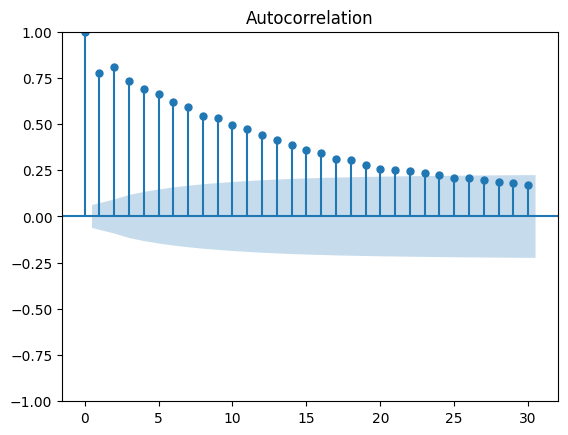

In [20]:
plot_acf(foot_traffic_diff, lags=30);

### Intuition of Partial Autocorrelation Function (**PACF**)
- Suppose we have the following AR(2) process: $y_t = 0.33y_{t–1} + 0.50y_{t–2}$
- In order to measure the correlation between $y_t$ and $y_{t-2}$,
    - Autocorrelation function (`ACF`) will capture both:
        - **Direct** impact of $y_{t-2}$ on $y_t$: 
            - i.e: $y_{t-2}$ &#8594; $y_t$
        - **In-direct** impact of $y_{t-2}$ on $y_t$ via $y_{t-1}$: 
            - i.e: $y_{t-2}$ &#8594; $y_{t-1}$ &#8594; $y_t$
            - This is because the $y_{t-2}$ also influencs on $y_{t-1}$ and $y_{t-1}$ then influences $y_t$
    - Partial Autocorrelation fuction (`PACF`) measures only the **direct** impact between each lag value, say  $y_{t-2}$, and the $y_t$ and remove the influence of correlated lagged values, say  $y_{t-1}$, in between (a.k.a. *confounding variables*)
        - The `PACF` to determine the order $p$ of a stationary $AR(p)$ process. 
            - The coefficients will be non-significant after lag $p$.

#### Simulating an AR process
- Suppose we have the following AR(2) process: $y_t = 0.33y_{t–1} + 0.50y_{t–2}$
- We will simulate it using the `ArmaProcess` function from `statsmodels`.
  - The function expects
    - An array containing the coefficients of an $MA(q)$ process.
      - Since we are only interested in simulating an $AR(2)$ process, we will set the coefficients of the $MA(q)$ process to 0
    - An array containing the coefficients for an $AR(p)$ process.
      - The coefficients of the AR(2) process must have **opposite signs** to those we wish to simulate. In this example, the array will contain `–0.33` and `–0.50`.
    - An coefficient at lag 0, which is the number that multiplies $y_t$ which is 1.


In [24]:
ma2 = np.array([1, 0, 0])                                            
ar2 = np.array([1, -0.33, -0.50])                                    
 
AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)    

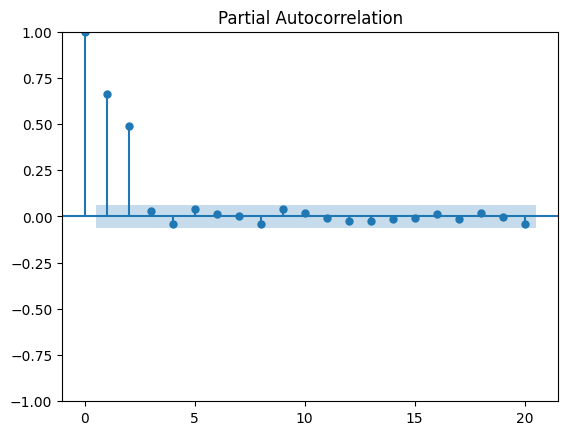

In [25]:
plot_pacf(AR2_process, lags=20);

- After lag 2, the partial autocorrelation coefficients are not significant.

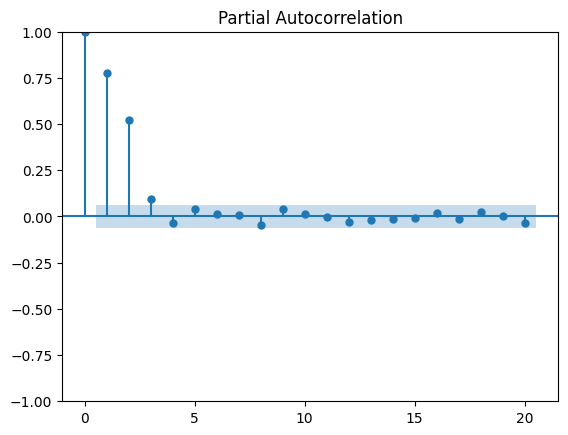

In [26]:
# Let’s apply the same strategy to our average weekly foot traffic
plot_pacf(foot_traffic_diff, lags=20);

- From the PACF plot, there are no significant coefficients after lag 3. 
- Therefore, the *differenced* average weekly foot traffic is an autoregressive process of order 3, which can also be denoted as $AR(3)$

## Forecasting an autoregressive process

In [27]:
# hold out the last 52 weeks of data for our test set, while the rest will be used for training.
df_diff = pd.DataFrame({'foot_traffic_diff': foot_traffic_diff})    
 
train = df_diff[:-52]                                               
test = df_diff[-52:]                                                
 
print(len(train))                                                   
print(len(test))  

947
52


- Use the `SARIMAX` function from `statsmodels` from statsmodels as it encompasses an AR model. 
- SARIMAX is a complex model that allows us to consider 
    - Seasonal effects
    - Autoregressive processes
    - Non-stationary time series
    - Moving average processes
    - Exogenous variables

In [32]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int,  window: int, method: str, p: int = 0) -> list:
    
    total_len = train_len + horizon
    # end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
 
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(p,0,0))      
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [33]:
TRAIN_LEN = len(train)                      
HORIZON = len(test)                         
WINDOW = 1                                  
 
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')    
pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR', 3)
 
test['pred_mean'] = pred_mean               
test['pred_last_value'] = pred_last_value   
test['pred_AR'] = pred_AR                   
 
test.head()

,foot_traffic_diff,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_diff[-70:].index, y=df_diff[-70:]['foot_traffic_diff'], name='actual', line = dict(color='royalblue')))

for pred_type in ["pred_mean", "pred_last_value","pred_AR"]: 
    fig.add_trace(go.Scatter(x=test.index, y=test[pred_type], name=pred_type, line = dict(dash='dash')))
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [439, 468, 498],
        ticktext = ['Apr', 'May', 'Jun']
    ),
    yaxis_title='Avg. Weekly Foot Traffic - Diff',
    xaxis_title='Time',
    title='Forecasts of the <b>differenced</b> average weekly foot traffic in a retail store'
)  
fig.show()

- Historical mean produces a straight line, this is expected as the mean is based on the differenced time-series, which is stationary, so the mean remains constant over the time of the stationary time series.

In [39]:
mse_mean = mean_squared_error(test['foot_traffic_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['foot_traffic_diff'], test['pred_last_value'])
mse_AR = mean_squared_error(test['foot_traffic_diff'], test['pred_AR'])
 
print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479169193074


- Since the MSE for the $AR(3)$ model is the lowest of the three, we conclude that the $AR(3)$ model is the best-performing method for forecasting next week’s average foot traffic.

- Next step: to bring our forecasts back to the original scale of the data
    - To do this, we can take the cumulative sum of our predictions and add it to the last value of our training set in the original series. 

In [56]:
df['pred_foot_traffic'] = pd.Series()
df['pred_foot_traffic'][948:] = df['foot_traffic'].iloc[947] + test['pred_AR'].cumsum() 

In [57]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-70:].index, y=df[-70:]['foot_traffic'], name='actual', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=df[-70:].index, y=df[-70:]["pred_foot_traffic"], name='AR(3) pred', line = dict(dash='dash')))
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [936, 988],
        ticktext = [2018, 2019]
    ),
    yaxis_title='Avg. Weekly Foot Traffic',
    xaxis_title='Time',
    title='Forecasts of the average weekly foot traffic in a retail store'
)  
fig.show()

In [58]:
mae_AR_undiff = mean_absolute_error(df['foot_traffic'][948:], df['pred_foot_traffic'][948:])
print(mae_AR_undiff)

2.8687972966682875


- This means that our predictions are off by 2.87 people on average, either above or below the actual value for the week’s foot traffic. 